# A/B Test - Food Chain Campaign

## Table of Content
- [Introduction](#Introduction)
- [Data Loading](#Data-Loading)
- [Analysis](#Analysis)
- [Conclusions](#Conclusions)

## Introduction

A fast-food chain is testing three marketing campaigns to promote a new menu item. The item is launched in randomly selected markets, with each location assigned a different campaign. Weekly sales are tracked over four weeks to evaluate which promotion drives the highest performance.

The goal of the analysis is to determine which strategy works at its best by reviewing the A/B test results along with data visualisation.

## Data Loading

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, chi2_contingency, kruskal, gaussian_kde
import scikits.bootstrap as bootstrap
import streamlit as st

pd.set_option("display.max_columns", None)

In [3]:
# Load the csv file
data = pd.read_csv("WA_Marketing-Campaign.csv")

In [4]:
# Print dataset main information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [5]:
# Print first few lines from the dataset
data.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


The dataset contains the following columns that will be used for the analysis:

- MarketID: unique identifier for market
- MarketSize: size of market area by sales
- LocationID: unique identifier for store location
- AgeOfStore: age of store in years
- Promotion: one of three promotions that were tested
- week: one of four weeks when the promotions were run
- SalesInThousands: sales amount for a specific LocationID, Promotion, and week

All the metrics here, except for "SalesInThousands" are randomly picked up, means that there should not be any dependency between them. The impact of each Promotion will be then evaluated on the size of Sales, hence the A/B test becomes important to verify if any increase or decrease is actually due to the Promotion or other factors.

"SalesInThousand" is the analyzed metric since reflects the actual impact of the promotions on the revenue.

In [6]:
# Review values for each metric and the frequency of each value
location = pd.DataFrame(columns=["Value", "Frequency"])
unique_values = data["LocationID"].unique()
for i in range(len(unique_values)):
    location.loc[i] = [
        unique_values[i],
        data["LocationID"].value_counts()[unique_values[i]],
    ]
location

,Value,Frequency
0,1,4
1,2,4
2,3,4
3,4,4
4,5,4
...,...,...
132,916,4
133,917,4
134,918,4
135,919,4


In [7]:
# Review values for LocationID
data["LocationID"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
       101, 102, 103, 104, 105, 106, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 301, 302, 303, 304, 305, 306, 307, 308, 309, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513,
       514, 515, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611,
       612, 613, 614, 615, 701, 702, 703, 704, 705, 706, 707, 708, 709,
       710, 711, 712, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810,
       901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913,
       914, 915, 916, 917, 918, 919, 920])

The groceries have been evenly distributed among the locations: a total of 137 spots have been considered, and 4 stores where checked for each of these.

In [8]:
# Drop rows with NaN values in the 'week' column
data_cleaned = data.dropna(subset=["week"])

week = pd.DataFrame(columns=["Value", "Frequency"])
unique_values = data_cleaned["week"].unique()
for i in range(len(unique_values)):
    week.loc[i] = [
        unique_values[i],
        data_cleaned["week"].value_counts()[unique_values[i]],
    ]
week.sort_values(by="Value", ascending=True, inplace=True)
week

,Value,Frequency
0,1,137
1,2,137
2,3,137
3,4,137


The samples have been collected evenly during the 4 weeks.

In [9]:
# Review values for MarketSize

data["MarketSize"].value_counts()

MarketSize
Medium    320
Large     168
Small      60
Name: count, dtype: int64

A significant difference is spotted for the stores size. For the context of this testing a deeper investigation will not be performed, but the impact on the Sales is show in the Dashboard.

In [10]:
# Create a table showing the unique values of the Age of Store and their frequency
age = pd.DataFrame(columns=["Value", "Frequency"])
unique_values = data["AgeOfStore"].unique()
for i in range(len(unique_values)):
    age.loc[i] = [unique_values[i], data["AgeOfStore"].value_counts()[unique_values[i]]]
age.sort_values(by="Value", ascending=True, inplace=True)
age

,Value,Frequency
3,1,80
14,2,20
12,3,32
0,4,44
1,5,44
6,6,36
13,7,40
8,8,40
16,9,28
4,10,24


From the table above is clear how the age distribution is not even. Particularly, the amount of stores within 1 year of age is significantly higher than the others. To give an utter understanding though, a chart is used.

C:\Users\pietr\AppData\Local\Temp\ipykernel_3228\3674834299.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="AgeOfStore", data=data, palette=colors)
C:\Users\pietr\AppData\Local\Temp\ipykernel_3228\3674834299.py:7: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.countplot(x="AgeOfStore", data=data, palette=colors)


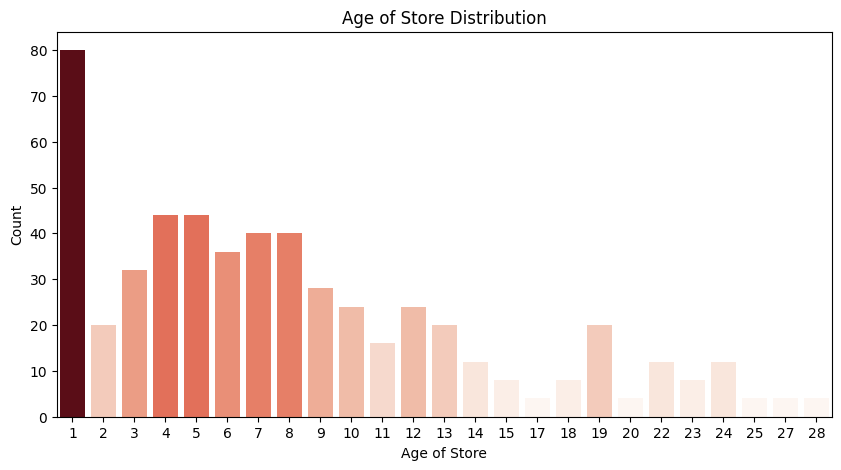

In [11]:
# Print the the representation of the values in the AgeOfStore column
plt.figure(figsize=(10, 5))
norm = (age["Frequency"] - age["Frequency"].min()) / (
    age["Frequency"].max() - age["Frequency"].min()
)
colors = sns.color_palette("Reds", as_cmap=True)(norm)
sns.countplot(x="AgeOfStore", data=data, palette=colors)
plt.title("Age of Store Distribution")
plt.xlabel("Age of Store")
plt.ylabel("Count")

plt.show()

This results is significant since the age might impact directly the effect on the promotion: are the newest stores more attracting for the customer ? Or they rely more on long-dated ones ? Such question can be answered by the A/B Test

## Analysis

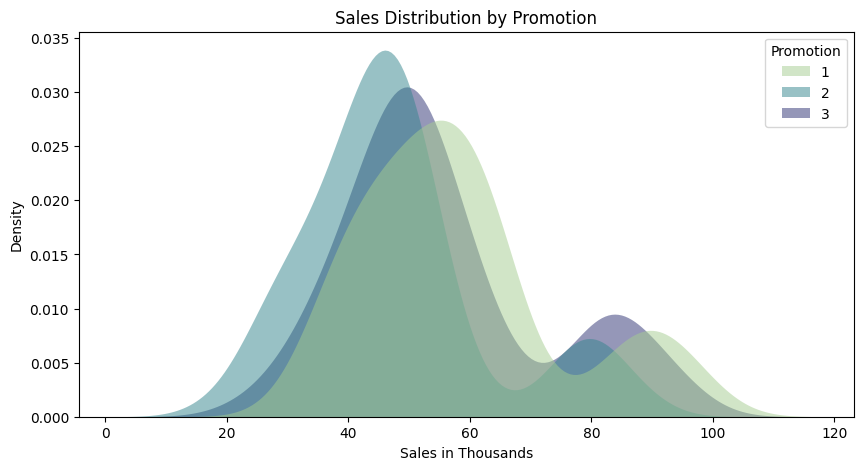

In [12]:
# Printing the distribution of the Sales for the three distribution
plt.figure(figsize=(10, 5))
sns.kdeplot(
    data=data,
    x="SalesInThousands",
    hue="Promotion",
    fill=True,
    common_norm=False,
    palette="crest",
    alpha=0.5,
    linewidth=0,
)
plt.title("Sales Distribution by Promotion")
plt.xlabel("Sales in Thousands")
plt.ylabel("Density")
plt.show()

It is noticed that the distributions are not fully normal: all of them are skewed to the left side on different gradient and they present a smaller bump on the right side.

At the first sight, the Promotion 1 has the biggest revenue, as the median is located around 60 k.

The A/B test will tell if such results are actually indipendent from each other and reppresenting a real the most effective Promotion.

In [13]:
# Sales main statistics
data["SalesInThousands"].describe()

count    548.000000
mean      53.466204
std       16.755216
min       17.340000
25%       42.545000
50%       50.200000
75%       60.477500
max       99.650000
Name: SalesInThousands, dtype: float64

### Sampling ratio mismatching

This check is performed beforehand to detect if the sample has been evenly randomized. This is indeed a foundamental hypotheisis in the test and if not confirmed can lead to mislead interpretations.

In [14]:
promotion = pd.DataFrame(columns=["Value", "Frequency"])
unique_values = data["Promotion"].unique()
for i in range(len(unique_values)):
    promotion.loc[i] = [
        unique_values[i],
        data["Promotion"].value_counts()[unique_values[i]],
    ]
promotion.sort_values(by="Value", ascending=True, inplace=True)
promotion

,Value,Frequency
2,1,172
1,2,188
0,3,188


The promotions have been evenly distributed,with a slight difference of 3% that should not have a huge impact of the final result. 
To verify further, we use the Kruskal-Wallis test: this is a non-parametric statistical test used to compare more than two groups and tells if at least one group is different from the others.
Due to its suitability for skewed data, as in our example, it has been chosen for this test.

In [15]:
stat, p = kruskal(
    data.loc[data["Promotion"] == 1]["SalesInThousands"],
    data.loc[data["Promotion"] == 2]["SalesInThousands"],
    data.loc[data["Promotion"] == 3]["SalesInThousands"],
)

print(f"Kruskal-Wallis test statistic: {stat}")
print(f"p-value: {p}")

Kruskal-Wallis test statistic: 53.29475169322799
p-value: 2.6741866266697816e-12


The results is expected due to the big size of the sample that makes the distributions pretty different from each other. In addition we run a pair-wise Mann–Whitney U test to verify what's the difference between the 3 promotio pairs.

In [16]:
# Calculate the Mann-Whitney U test for each pair of promotions

for i in range(1, 4):
    for j in range(i + 1, 4):
        stat, p = mannwhitneyu(
            data.loc[data["Promotion"] == i]["SalesInThousands"],
            data.loc[data["Promotion"] == j]["SalesInThousands"],
        )
        print(f"Mann-Whitney U test statistic (Promotion {i} vs Promotion {j}): {stat}")
        print(f"p-value (Promotion {i} vs Promotion {j}): {p}")
        print("\n")

Mann-Whitney U test statistic (Promotion 1 vs Promotion 2): 22957.5
p-value (Promotion 1 vs Promotion 2): 5.845935246838518e-12


Mann-Whitney U test statistic (Promotion 1 vs Promotion 3): 18247.0
p-value (Promotion 1 vs Promotion 3): 0.035084095693231204


Mann-Whitney U test statistic (Promotion 2 vs Promotion 3): 12093.0
p-value (Promotion 2 vs Promotion 3): 1.1970084441651803e-07




We notice that generally there is a significant difference between the three promotions, despite the p-value between version 1 and 3 is pretty close to the standard limit of 0.05. Different promotion leads hence to different sales income.

### Sanity Check

This step is performed to verify the independence between the metrics. Since we are using these for evaluating the effect of our promotion, testing with dependent metrics would lead to incorrect interpretation of the results. The A/B test in this case consists indeed in verifying if any proportion is more effective than another, allegedly without any relation with it.

To perform this control, we run a Chi-squared Test between the AgeOfStores and Promotion metrics. If the independency is proven, then we can make some assumptions regarding the impact on the Sales.

- Expected distribution of users: 33.3 % 
- Calculate the Chi-square statistic: $$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$$
- Compare the Chi-Square statistic with p-value

#### Sales vs Age of Stores

The following analysis identifies the relationships between these two metrics

By transforming the continuous variable AgeOfStores into a categorical type, we can use the Chi-square test. 

In [17]:
# Create a contingency table for the promotion and the age of the store
# Ensure the maximum value in bins is greater than 75

sales_categorized = pd.cut(
    data["SalesInThousands"],
    bins=[0, 25, 50, 75, float("inf")],
    labels=["1-25 k", "26-50 k", "51-75 k", "76+ k"],
    right=True,
)

In [18]:
# Create a contingency table for the promotion and the age of the store
data["AgeRange"] = pd.cut(
    data["AgeOfStore"],
    bins=[0, 5, 8, 13, float("inf")],
    labels=["0-5", "6-8", "9-13", "13+"],
    right=True,
)

table = pd.crosstab(data["AgeRange"], sales_categorized)
table

SalesInThousands,1-25 k,26-50 k,51-75 k,76+ k
AgeRange,,,,
0-5,4,99,71,46
6-8,1,64,36,15
9-13,4,60,36,12
13+,0,37,52,11


In [19]:
# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-squared test statistic: {chi2}")
print(f"p-value: {p}")
# Print the expected frequencies
print("Expected frequencies:")
print(expected)

Chi-squared test statistic: 26.555441928624198
p-value: 0.0016561737712404378
Expected frequencies:
[[  3.61313869 104.37956204  78.28467153  33.72262774]
 [  1.90510949  55.03649635  41.27737226  17.7810219 ]
 [  1.83941606  53.13868613  39.8540146   17.16788321]
 [  1.64233577  47.44525547  35.58394161  15.32846715]]


The p-value is smaller than 0.05, expressing a clear dependence between the age of the store and the amount of Sales

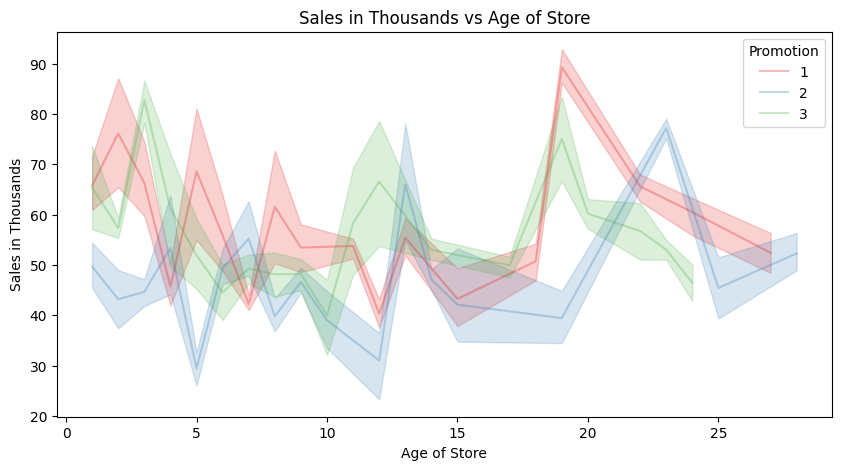

In [20]:
# Print distribution of the sales in thousands over the age of the store
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=data,
    x="AgeOfStore",
    y="SalesInThousands",
    hue="Promotion",
    alpha=0.3,
    palette="Set1",
)
plt.title("Sales in Thousands vs Age of Store")
plt.xlabel("Age of Store")
plt.ylabel("Sales in Thousands")
plt.legend(title="Promotion")
plt.show()

The plot show clearly how the Promotion 1 is more effective in relation to the Sales amount, with two visible spikes for nearly and long established stores. On the other hands, the Promotion 3 follows a similar evolution with an upsurge in sales for the stores within 10 - 15 years of activity. The Promotion 2 seems to be the least effective, registering spikes for medium and long time established shops. 

### Sales vs Week

In [21]:
# Create a contingency table for Sales and week
table = pd.crosstab(data["week"], sales_categorized)

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(table)
print(f"Chi-squared test statistic: {chi2}")
print(f"p-value: {p}")
# Print the expected frequencies
print("Expected frequencies:")
print(expected)

Chi-squared test statistic: 2.505006105006105
p-value: 0.9807485577253386
Expected frequencies:
[[ 2.25 65.   48.75 21.  ]
 [ 2.25 65.   48.75 21.  ]
 [ 2.25 65.   48.75 21.  ]
 [ 2.25 65.   48.75 21.  ]]


In this case, the p-value is bigger than 0.05, hence we cannot reject the null hypothesis: there is no apparent connection between the week and the Sales revenue. This means that the week metric can be used to evaluate which of the Promotion is more effective sales-wise.

<Figure size 1000x500 with 0 Axes>

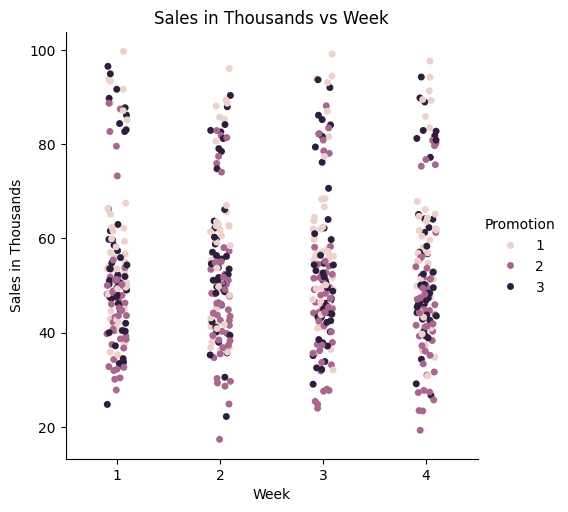

In [22]:
plt.figure(figsize=(10, 5))
sns.catplot(data=data, x="week", y="SalesInThousands", hue="Promotion")
plt.title("Sales in Thousands vs Week")
plt.xlabel("Week")
plt.ylabel("Sales in Thousands")
plt.show()

From the above chart again is visible how the Promotion 1 is engaging the highest scores in sales

### Confidence interval

The aim to calculate the confidence interval in this case is to identify the interval that the sales can vary within. By considering the standard value of 95%, we can claim that the sales increase (or decrease) is included between two values

#### Manual calculation

In [23]:
# Calculate the standard deviation for each promotion group
def standard_error(data, n):
    return np.std(data.loc[data["Promotion"] == n]["SalesInThousands"]) / np.sqrt(
        len(data["Promotion"])
    )


std = []

for i in range(1, 4):
    std.append(standard_error(data, i))
    print(f"Standard deviation for Promotion {i}: {standard_error(data, i)}")

Standard deviation for Promotion 1: 0.7050838644735955
Standard deviation for Promotion 2: 0.6437037228388643
Standard deviation for Promotion 3: 0.714310508063356


In [24]:
# Set the critical value
z = 1.96

In [25]:
# Calculate the margin of error for each promotion group
def margin_of_error(std, z):
    return z * std


me = []

for i in range(1, 4):
    me.append(margin_of_error(std[i - 1], z))
    print(f"Margin of error for Promotion {i}: {margin_of_error(std[i-1], z)}")

Margin of error for Promotion 1: 1.3819643743682473
Margin of error for Promotion 2: 1.261659296764174
Margin of error for Promotion 3: 1.4000485958041777


In [26]:
# Calculate the confidence interval for each promotion group
def confidence_interval(data, me, n):
    mean = np.mean(data.loc[data["Promotion"] == n]["SalesInThousands"])
    return (mean - me, mean + me)


for i in range(1, 4):
    print(
        f"Confidence interval for Promotion {i}: {np.round(confidence_interval(data, me[i-1], i),2)}"
    )

Confidence interval for Promotion 1: [56.72 59.48]
Confidence interval for Promotion 2: [46.07 48.59]
Confidence interval for Promotion 3: [53.96 56.76]


In [27]:
# Calculate the median for each promotion group
for i in range(1, 4):
    print(
        f"Median for Promotion {i}: {round(np.median(data.loc[data['Promotion'] == i]['SalesInThousands']),2)}"
    )

Median for Promotion 1: 55.39
Median for Promotion 2: 45.39
Median for Promotion 3: 51.16


In [28]:
# Calculate the mean for each promotion group
for i in range(1, 4):
    print(
        f"Mean for Promotion {i}: {round(np.mean(data.loc[data['Promotion'] == i]['SalesInThousands']),2)}"
    )

Mean for Promotion 1: 58.1
Mean for Promotion 2: 47.33
Mean for Promotion 3: 55.36


The mean for each proportion is slightly bigger than the median, reflecting the non-normality of the distribution.

#### Confidence interval with Bootstrap method

In [29]:
# Calculate thr 95% confidence interval with the bootstrap method
for i in range(1, 4):
    ci = bootstrap.ci(
        data.loc[data["Promotion"] == i]["SalesInThousands"],
        statfunction=np.mean,
        alpha=0.05,
        method="bca",
    )
    print(f"BCa 95% confidence interval for Promotion {i}:", ci)

BCa 95% confidence interval for Promotion 1: [55.74162791 60.67151163]
BCa 95% confidence interval for Promotion 2: [45.24260638 49.56984043]
BCa 95% confidence interval for Promotion 3: [53.0512234 57.8118617]


95% CI Promotion 2 - Promotion 1 : [-11.985  -8.08 ]
95% CI Promotion 3 - Promotion 1 : [-6.155 -1.615]
95% CI Promotion 3 - Promotion 2 : [3.865 7.435]


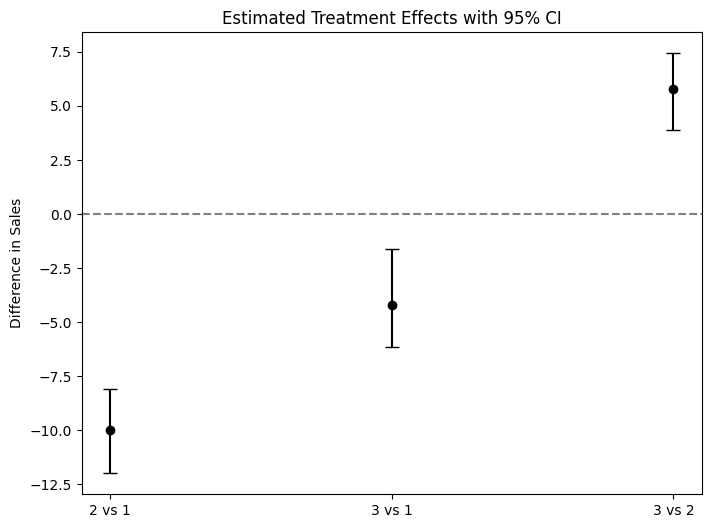

In [ ]:
# Treatment effect function -  impact of your treatment (or change) compared to the control, in this case as difference in medians
def treatment_effect(data, axis=None):
    A = data[:, 0]
    B = data[:, 1]
    return np.median(B, axis=axis) - np.median(A, axis=axis)


plt.figure(figsize=(8, 6))

# For plotting multiple pairs at different x positions
x_pos = 0

# Loop over promotion pairs
for i in range(1, 4):
    for j in range(i + 1, 4):
        sales_A = data.loc[data["Promotion"] == i, "SalesInThousands"].values
        sales_B = data.loc[data["Promotion"] == j, "SalesInThousands"].values

        min_size = min(len(sales_A), len(sales_B))
        data_ete = np.column_stack([sales_A[:min_size], sales_B[:min_size]])

        # Bootstrap CI
        ci = bootstrap.ci(
            data=data_ete, statfunction=treatment_effect, alpha=0.05, method="bca"
        )

        treatment_estimate = np.median(sales_B) - np.median(sales_A)

        # Plot each pair at different x
        # Ensure yerr values are non-negative
        lower_error = max(0, treatment_estimate - ci[0])
        upper_error = max(0, ci[1] - treatment_estimate)

        plt.errorbar(
            x=[x_pos],
            y=[treatment_estimate],
            yerr=[[lower_error], [upper_error]],
            fmt="o",
            capsize=5,
            color="black",
            label=f"Promo {i} vs {j}" if x_pos == 0 else "",
        )

        print(f"95% CI Promotion {j} - Promotion {i} : {ci}") #confidence interval gives range of plausible values for the treatment effect, hence the difference of the median more/less the margin of error
        x_pos += 1  # move x position for next pair

# Draw baseline
plt.axhline(0, color="gray", linestyle="--")
plt.xticks(range(x_pos), [f"{j} vs {i}" for i in range(1, 4) for j in range(i + 1, 4)])
plt.ylabel("Difference in Sales")
plt.title("Estimated Treatment Effects with 95% CI")
plt.show()

The results above only confirm the previous observation: promotion 1 is more effective than the other two, where the range of sales difference (in thousands) is indicated. Furthermore, it confirms that the Promotion 3 is more effective than number 2.

It is noticed that the differece between the interval calculated analytically and those calculated with Bootstrap. This is due to the fact that the second method take no assumption, becoming suitable also for skewed and non-normal distribution, meanwhile the classic way is assuming an ideal distribution that is not happening in this case

As final step, the confidence interval is printed for all the distributions.

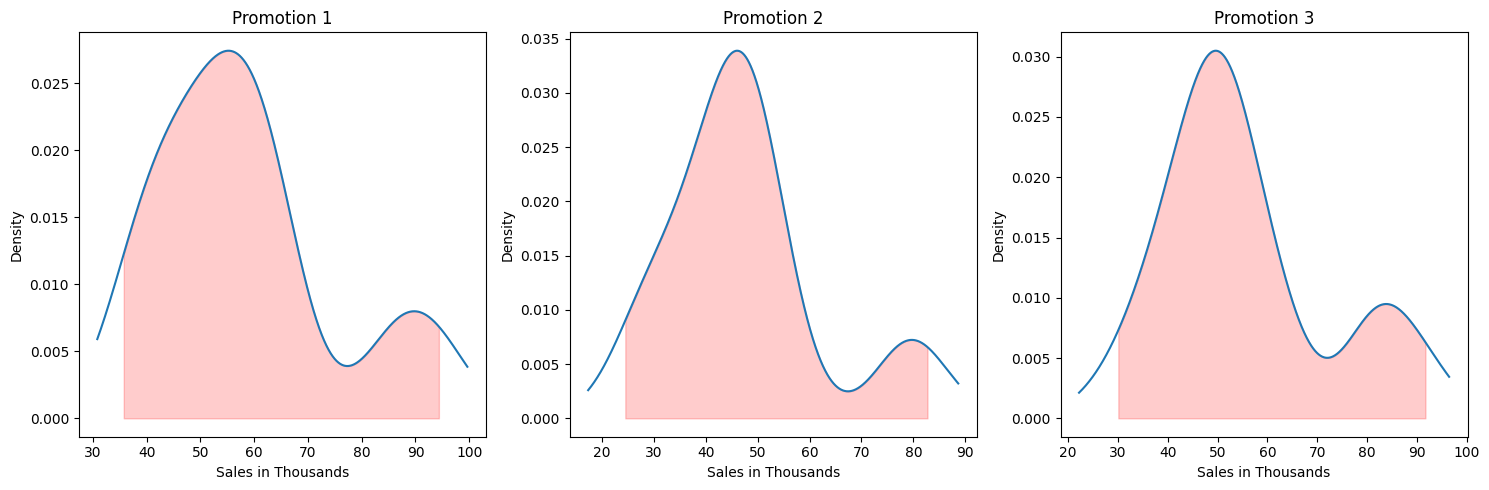

In [31]:
plt.figure(figsize=(15, 5))

for i in range(1, 4):
    plt.subplot(1, 3, i)
    # Calculate the percentiles for the SalesInThousands column for Promotion 1
    sales_promotion = data.loc[data["Promotion"] == i]["SalesInThousands"]
    lower = np.percentile(sales_promotion, 2.5)
    upper = np.percentile(sales_promotion, 97.5)

    # Calculate the density using gaussian_kde
    kde = gaussian_kde(sales_promotion)
    x = np.linspace(sales_promotion.min(), sales_promotion.max(), 10000)
    y = kde(x)

    # Plot the density
    plt.plot(x, y, label=f"Promotion {i}")

    # Highlight the confidence interval
    plt.fill_between(
        x,
        y,
        where=(x >= lower) & (x <= upper),
        color="red",
        alpha=0.2,
        label="Bootstrap CI",
    )

    plt.title(f"Promotion {i}")
    plt.xlabel("Sales in Thousands")
    plt.ylabel("Density")

plt.tight_layout()
plt.show()

## Conclusions

The final outcomes of the test are the following:
- the sample analysed had an unusual distribution that made the choice of the proper statistical tool a little challenging. Due to the time constraints, the documented approach was used but if I was in a real scenario, I would have rather split the population in two normal samples, right and left-skewed, and combined the results from the two bumps.
- a potential improvement would be to dig into the relationship between store size and revenue in Sales, since it has been noticed that the distribution was not even. Did it occur randomly or is it somehow related to the test engineering part ? Would be worth discussig with the stakeholders about this ? 
- overall, the results showed that the Promotion 1 is the most effective in terms of generated revenue. Further insights would be related to population type: age, gender, social status of the buyers. Do these features impact the Promotion engagement ? 